<a href="https://colab.research.google.com/github/lkscbrl/e-commerce/blob/main/Parte_1_Coleta_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Coleta de ofertas do e-commerce

Nós iremos desenvolver uma aplicação de **web scraping¹** para coletar ofertas na plataforma [Zoom.com.br](https://www.zoom.com.br/), um website que começou como comparador de preços e que hoje possui um ecosistema completo de soluções para o e-commerce. ***Vale ressaltar que a coleta de dados se dá para fins acadêmicos apenas.***

A aplicação foi desenvolvida em Python (versão 3.7) utilizando o Google Colaboratory, uma plataforma que permite rodar gratuitamente notebooks na nuvem sem a necessidade de instalação, com uma capacidade inicial de 13GB de memória RAM (podendo chegar a 25GB caso você estoure a memória inicial) e 108GB de armazenamento, e que pode ser integrada ao Google Drive para consultar seus arquivos armazenados.

***¹ Web scraping é o nome dado para o processo automatizado de coleta de dados 
em websites.***

##Antes de inciarmos...

É importante reforçarmos que alguns sites não permitem a atividade de web scraping por diversos motivos, mas principalmente porque um grande número de requisições pode causar lentidão em seus servidores. Para conferir as permissões do site alvo basta adicionar [/robots.txt](https://www.zoom.com.br/robots.txt) no final da URL de sua página inicial. Na imagem abaixo temos alguns exemplos de páginas que o site não permite o acesso automatizado:

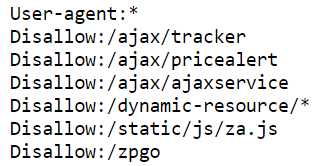

Caso o usuário insista em ignorar as permissões o site pode penaliza-lo, criando bloqueios temporários ou permanentes, e pode inclusive tomar providências legais. Para mais detalhes busque pelos [termos de uso do site](https://www.zoom.com.br/termos-de-uso).

##Dito isso, vamos começar!
Primeiro precisamos importar as bibliotecas necessárias para a nossa aplicação. Abaixo temos uma breve descrição para cada uma:


In [20]:
from bs4 import BeautifulSoup   # utlizada para análise de documentos em formato HTML
import requests                 # utilizada para fazer requisições http
import pandas as pd             # principal biblioteca para análise de bases de dados em formato tabular
import re                       # biblioteca para trabalhar com expressões regulares
import random                   # utilizada para gerar números pseudo-aleatórios
import time                     # utilizada para computar o tempo de execução do código
import datetime                 # biblioteca para trabalhar com datas

Logo em seguida iremos definir algumas variáveis que faremos uso:

In [21]:
# endereço do site que iremos rodar nossa aplicação
url = 'https://www.zoom.com.br' 

# lista com as categorias de produtos que iremos buscar
categories = ['/tv', '/ar-condicionado', '/geladeira', '/microondas',
              '/lavadora-roupas'] 

# número de páginas por categoria que iremos buscar
pages = 5 

#User-agent e Cabeçalho
Como mencionado anteriormente, o site bloqueia o acesso de aplicações automatizadas, então precisaremos simular nossos acessos para que sejam confundidos com acessos de pessoas reais. Abaixo temos o cabeçalho que será enviado junto com a solicitação http:

In [22]:
headers = {'accept-encoding':'gzip, deflate, br',
           'referer': 'https://www.zoom.com.br/', 
           'accept-language':'pt-BR,pt;q=0.9', 
           'cache-control':'max-age=0', 
           'sec-fetch-dest':'document', 
           'sec-fetch-mode':'navigate', 
           'sec-fetch-site':'same-origin', 
           'sec-fetch-user':'?1', 
           'upgrade-insecure-requests':'1', 
           'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36'}

Na internet conseguimos encontrar facilmente listas de cabeçalhos para usarmos em nossas aplicações, mas caso deseje utilizar seu próprio cabeçalho basta acessar as ferramentas para desenvolvedores apertando a tecla F12 e navegar até a aba network para consultar os detalhes de cada requisição:

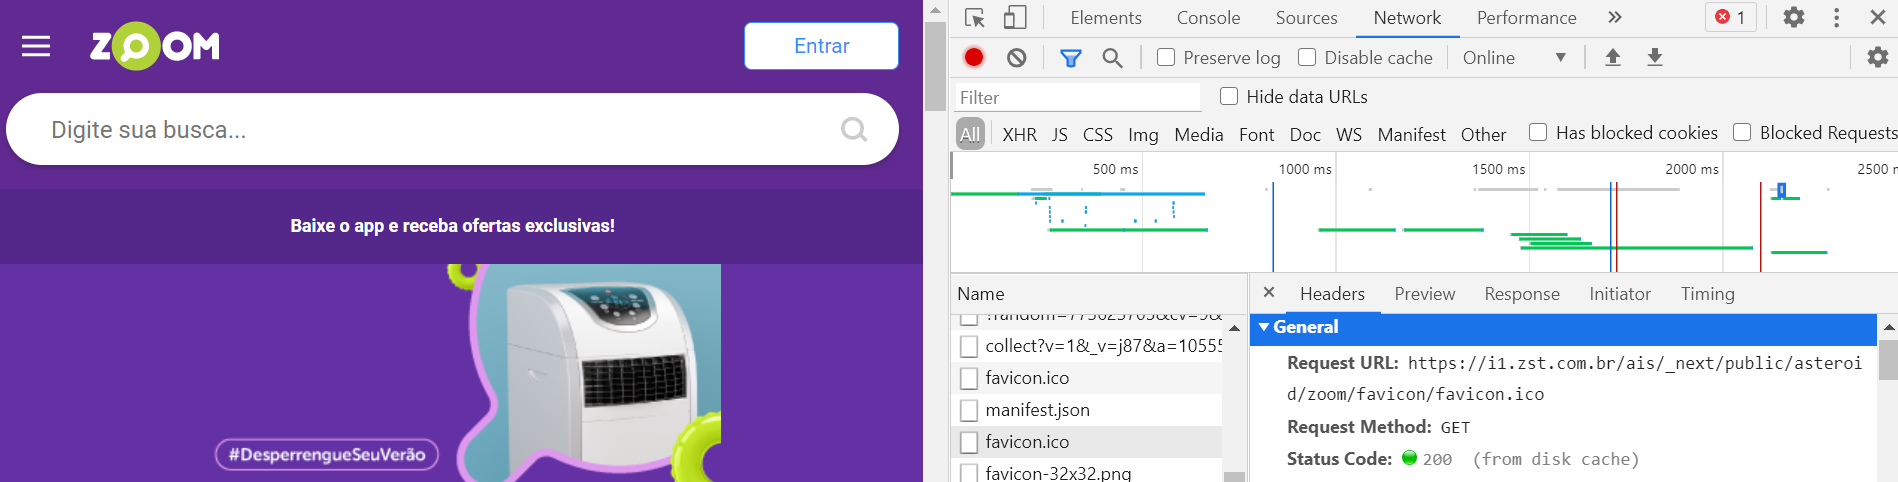

#Proxy

Nossa aplicação já consegue enviar requisições http simulando o acesso de pessoas reais, entretanto, o alto número de requisições em um curto período de tempo acaba nos denunciando e o site bloqueia o nosso endereço de IP após algumas centenas de acessos. Sendo assim, iremos definir uma estratégia para trocar nosso endereço aleatóriamente dentro de uma lista de endereços de IP que iremos fornecer. 

###"Como assim? posso passar qualquer endereço de IP que a aplicação irá funcionar?" - NÃO!

Iremos utlizar servidores proxy, que são servidores que intermediam os nossos acessos na internet. Em outras palavras, nós enviamos uma requisição para um servidor e ele repassa para o endereço final, adicionando uma camada de proteção. 

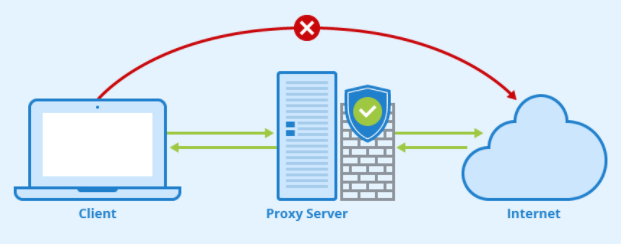

Os servidores proxy podem ser gratuitos ou pagos, e oferecem diferentes níveis de anonimato, mas para essa nossa aplicação não precisaremos de nada muito elaborado então utilizaremos uma [lista de proxys gratuitos](https://www.proxynova.com/proxy-server-list/country-br/):

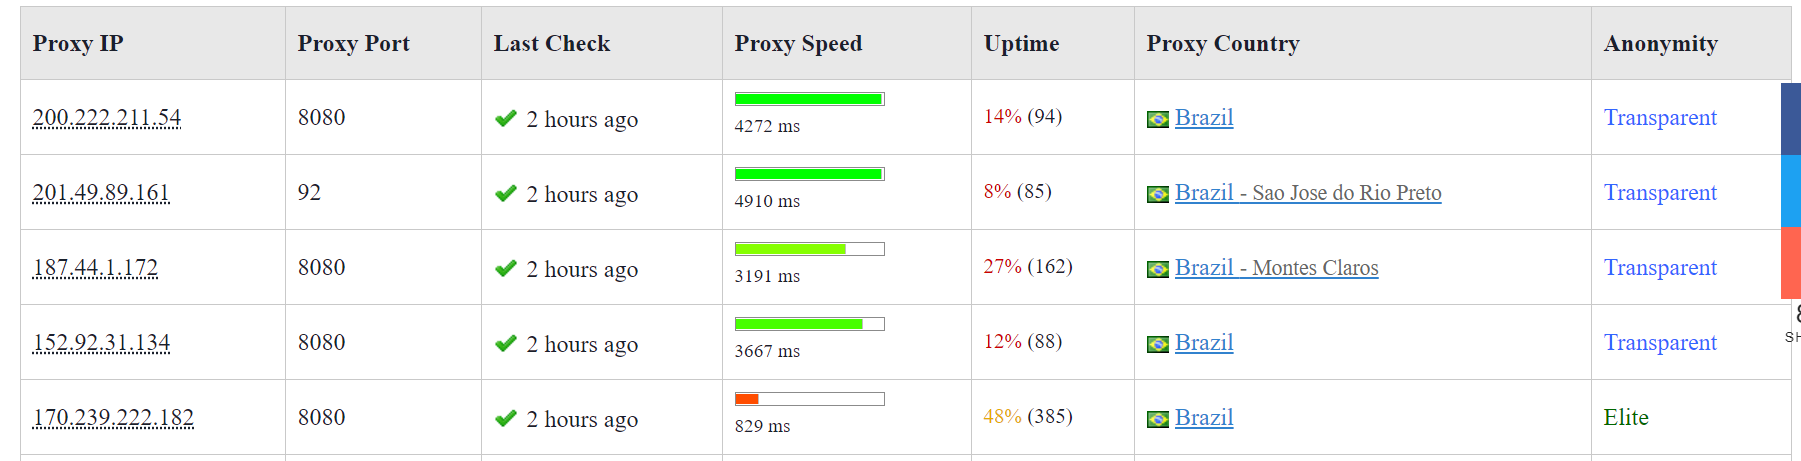

***Obs: Vale ressaltar que o uso de proxy oferece alguns riscos pois estamos usando uma conexão que não é segura, então evite utilizar dados sensíveis e procure se informar.***

Como a lista disponibilizada no site muda constantamente e não queremos ter que coletar manualmente, definiremos abaixo algumas funções que farão essa busca por nós.

In [23]:
def get_proxies(url='https://www.proxynova.com/proxy-server-list/country-br/', target=url, verbose=False):

  # iniciamos a contagem de tempo
  start = time.time()

  # incializamos uma lista vazia para armazenarmos nossos proxies
  proxies = list()

  # enviamos uma requisição para o site que disponibiliza a lista de proxies do Brasil
  r = requests.get(url, headers=headers)

  # utilizamos o Beautifulsoup para análisar o código fonte da página para a qual enviamos a requisição
  soup = BeautifulSoup(r.text, 'html.parser')

  # a página disponibiliza os proxies em uma tabela, sendo a primeira coluna o endereço e a segunda coluna a porta de entrada
  # iremos analisar cada linha da tabela(tr = table row)
  for tr in soup.find_all('tr'):

    # aplicaremos duas expressões regulares no texto de cada linha da tabela para localizar os itens que precisamos
    # também seria possível buscar pelo número da coluna, mas acredito que dessa maneira temos mais flexbilidade caso a estrutura
    ip = re.search(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', tr.text)
    port = re.search(r'[0-9]{4}', tr.text)

    # verificamos se foi encontrado um valor tanto para o endereço quanto para a porta
    if ip is not None and port is not None:

      # ajustamos o proxy para o formato que nossa aplicação irá utilizar
      adress = 'http://' + str(ip.group()) + ':' + str(port.group())
      proxy = {'http': adress, 'https': adress}

      # chamamos uma função(definida logo em seguida) que fará a validação do proxy,
      # e caso a resposta seja positiva(código 200) o adicionaremos em nossa lista
      if validate_proxy(proxy, target, verbose) == 200:

        proxies.append(proxy)

  # pausamos o contador e informamos o usuário sobre o tempo gasto e a quantidade de proxies válidos
  end = time.time()

  print('====================================================================')
  print(f'Operação concluída em {str(datetime.timedelta(seconds=end-start))}')
  print(f'{len(proxies)} proxy válido(s).')

  return proxies

def validate_proxy(proxy, target, verbose=False):
  
  # enviamos uma requisição utilizando o proxy e caso ela seja completada retornamos o código de resposta
  try:

    r = requests.get(target, proxies=proxy, timeout=5)
    
    if verbose:
      print(f'{proxy} válido!')

    return r.status_code
  
  except:

    if verbose:
      print(f'{proxy} inválido!')

    pass

Agora faremos a busca por proxies. A URL passada na função é a do site alvo e o parametro `'verbose'` imprime para o usuário a resposta detalhada de cada teste realizado por proxy.

In [24]:
proxies = get_proxies(target=url, verbose=True)

{'http': 'http://170.239.222.182:8080', 'https': 'http://170.239.222.182:8080'} inválido!
{'http': 'http://45.6.229.34:8080', 'https': 'http://45.6.229.34:8080'} inválido!
{'http': 'http://200.0.40.134:8080', 'https': 'http://200.0.40.134:8080'} inválido!
{'http': 'http://187.62.195.39:8080', 'https': 'http://187.62.195.39:8080'} inválido!
{'http': 'http://177.141.243.73:8080', 'https': 'http://177.141.243.73:8080'} inválido!
{'http': 'http://187.125.23.26:8080', 'https': 'http://187.125.23.26:8080'} inválido!
{'http': 'http://187.44.1.167:8080', 'https': 'http://187.44.1.167:8080'} válido!
{'http': 'http://179.185.35.229:3128', 'https': 'http://179.185.35.229:3128'} inválido!
{'http': 'http://160.238.251.142:3128', 'https': 'http://160.238.251.142:3128'} inválido!
{'http': 'http://177.10.232.124:8080', 'https': 'http://177.10.232.124:8080'} inválido!
{'http': 'http://177.152.143.74:8080', 'https': 'http://177.152.143.74:8080'} válido!
{'http': 'http://201.49.72.226:8080', 'https': 'ht

In [25]:
print(proxies)

[{'http': 'http://187.44.1.167:8080', 'https': 'http://187.44.1.167:8080'}, {'http': 'http://177.152.143.74:8080', 'https': 'http://177.152.143.74:8080'}, {'http': 'http://177.37.240.52:8080', 'https': 'http://177.37.240.52:8080'}, {'http': 'http://177.155.215.89:8080', 'https': 'http://177.155.215.89:8080'}]


# Coleta de páginas por categoria de produto

Agora que já coletamos nossa lista de proxies, iremos fazer nosso primeiro acesso ao site alvo para coleta de dados. Abaixo definiremos uma função que busca produtos para cada uma das categorias em nossa lista. Após cada busca, iremos armazenar em uma lista o link de cada produto para acessarmos posteriormente.

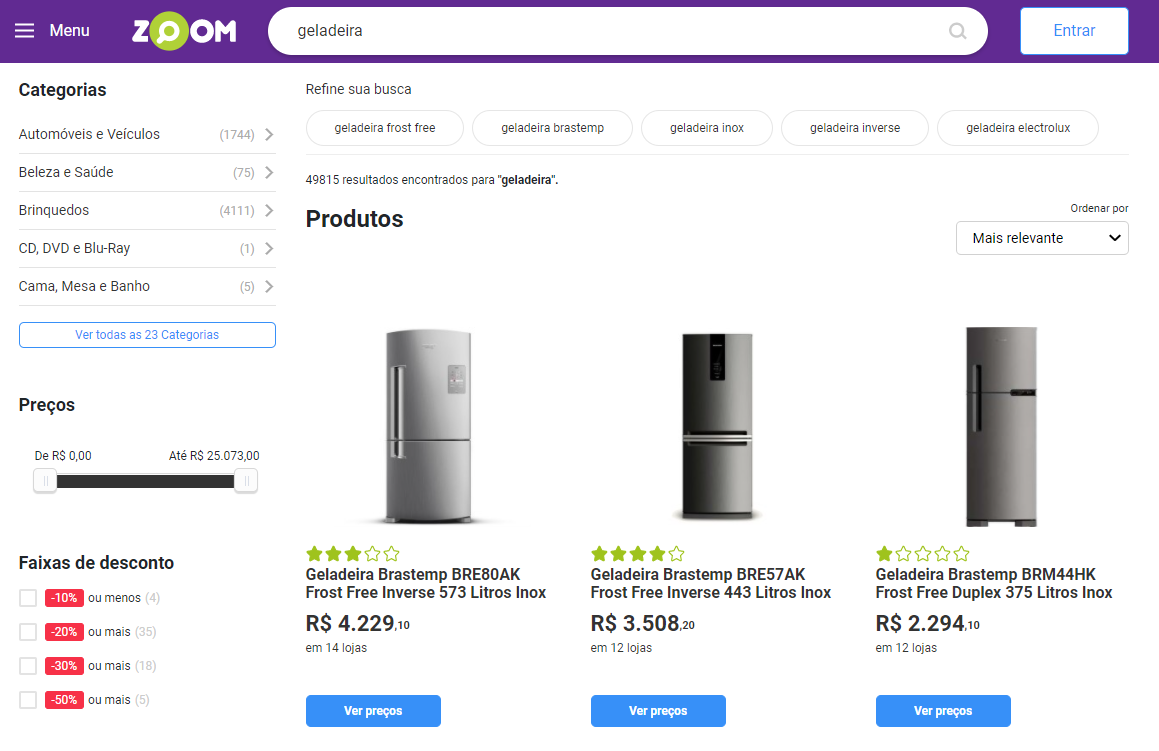

Nessa primeira busca não precisaremos usar nossos proxies pois o número de requisições é pequeno e não resulta em bloqueio.

In [26]:
def get_pages(url, categories, pages, headers):

  # incializamos nosso contador de tempo
  start = time.time()
  
  # iniciamos uma sessão para que sejam armazenados os cookies
  with requests.Session() as s:

    # inicializamos uma lista vazia para armazenarmos nossos links
    links = list()

    # iteramos cada item na lista de categorias
    for c in categories:

      # definimos o número da página para 1
      p = 1
      
      # iteramos esse bloco de código até que o número de páginas percorridas seja igual ao número que passamos ao chamar a função
      while p < pages:

        # fazemos uma requisição combinando nossa url inicial, a categoria, um complemento de texto e o número da página
        # dessa forma conseguimos navegar por diversas páginas apenas mudando os parâmetros na url
        r = s.get(url + c + '?page=' + str(p), headers=headers)

        # analisamos o código fonte da página com o beautifulsoup
        soup = BeautifulSoup(r.text, 'html.parser')

        # usamos uma expressão regular para encontrar o texto indicando que não tem mais produtos para visualizar
        # se a expressão retornar vazio continuamos para a extração do link, 
        # caso contrário cancelamos o laço e passamos para a próxima categoria da lista
        if re.search('Não foram encontrados resultados com o termo buscado', soup.text) is None:

          # somamos 1 na variável p para que na próxima iteração busquemos na próxima página
          p += 1

          # buscamos por itens com a tag 'a' cujo o parâmetro 'modifiers' tenha o valor 'system'
          # para encontrar essas tags, clique com o botão direito em cima do item que deseja buscar e clique em 'inspecionar'
          # o navegador abrirá as ferramentas de desenvolvedor, onde será possível navegar pela estrutura do site
          for link in soup.find_all('a', {'modifiers': 'system'}):

            # após encontrar o item, extraímos o atributo 'href'que é justamente o link e anexamos em nossa lista
            links.append([link.get('href').split('?_lc=')[0], c])

        else:
          break

      # imprimimos para o usuário a quantidade de páginas que iteramos por categoria
      print('Páginas encontradas para {} : {}'.format(c, p))

  # pausamos o contador e informamos o usuário sobre o tempo gasto e a quantidade de links válidos
  end = time.time()

  print('=====================================')
  print(f'Operação concluída em {str(datetime.timedelta(seconds=end-start))}')
  print(f'{len(links)} links encontrados')

  return links

Agora iremos rodar a função:

In [27]:
links = get_pages(url, categories, pages, headers)

Páginas encontradas para /tv : 5
Páginas encontradas para /ar-condicionado : 5
Páginas encontradas para /geladeira : 5
Páginas encontradas para /microondas : 5
Páginas encontradas para /lavadora-roupas : 5
Operação concluída em 0:00:09.405289
644 links encontrados


In [28]:
print(links[:5])

[['/tv/smart-tv-led-43-hq-4k-hqstv43ny-2-hdmi', '/tv'], ['/tv/smart-tv-led-32-samsung-serie-4-un32t4300agxzd-2-hdmi', '/tv'], ['/tv/smart-tv-led-50-samsung-serie-8-4k-un50tu8000gxzd-3-hdmi', '/tv'], ['/tv/smart-tv-led-43-samsung-4k-un43tu7000gxzd-2-hdmi', '/tv'], ['/tv/smart-tv-led-43-lg-thinq-ai-full-hd-43lm6300psb-3-hdmi', '/tv']]


#Coleta de ofertas

Chegou a parte que estávamos esperando! Iremos entrar em cada um dos links da etapa anterior para coletarmos dados como a descrição dos produtos, preços por loja e marca. Abaixo definimos uma função que fará essa busca.

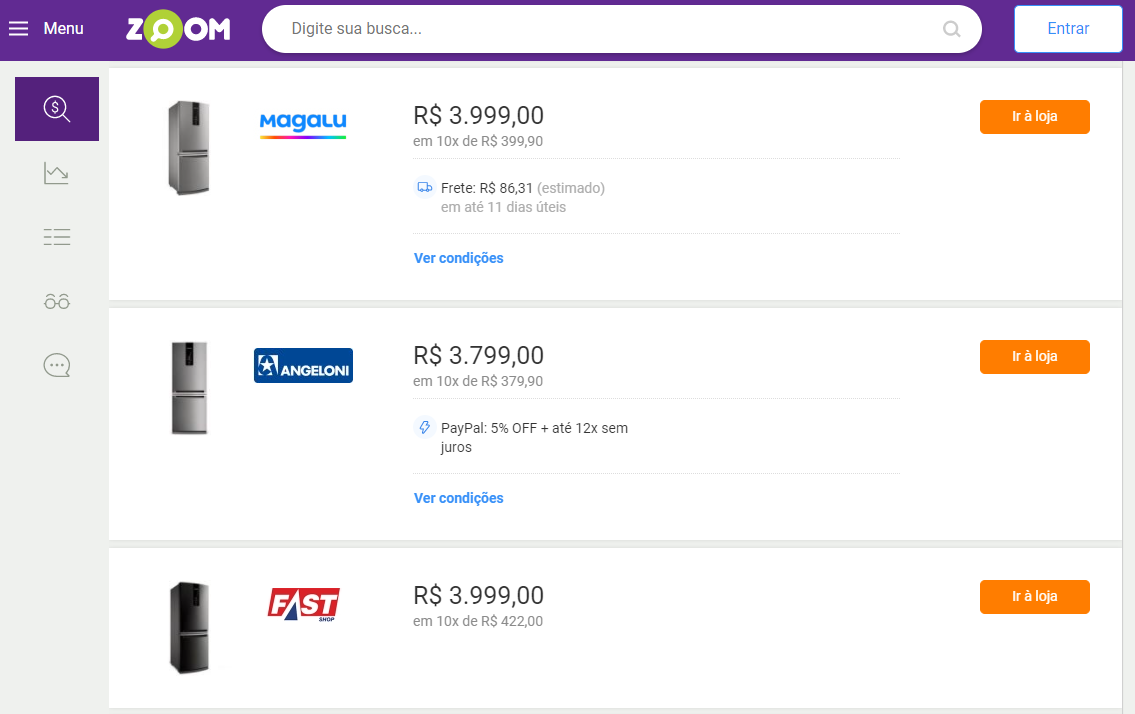

*Obs: Você perceberá que o valor padrão para os proxies na função é `{0:0}`, entretanto irei esclarecer mais para frente o motivo.*

In [29]:
def scrappy_data(url, links, headers, proxies={0:0}):

  # incializamos nosso contador de tempo
  start = time.time()

  # inicializamos uma lista para armazenar os erros
  errors = list()

  # inicializamos uma sessão para armazenarmos os cookies
  with requests.Session() as s:

    # inicializamos uma lista vazia para armazenarmos os dados coletados
    df = list()

    # enviamos uma primeira requisição sem proxies para a página inicial do site alvo para que fique salvo nos cookies da sessão
    s.get(url, headers=headers, timeout=5)

    # agora iremos iterar cada item da lista de links
    for l in links:

      # escolhemos aleatóriamente um proxy da nossa lista que mudará a cada iteração
      proxy = random.choice(proxies)

      try:

        # fazemos a requisição utilizando o proxy escolhido
        r = s.get(url + l[0], headers=headers, proxies=proxy, timeout=5)

        # analisamos o código fonte da página
        soup = BeautifulSoup(r.text, 'html.parser')

        # localizamos a descrição do produto buscando pela tag 'h1', com a classe 'OverviewArea_TitleText__1s_GP'
        desc = soup.find('h1', {'class': 'OverviewArea_TitleText__1s_GP'}).text

        # localizamos a marca do produto buscando pela tag 'th' e com o texto 'Marca'
        # Como está em uma tabela precisamos pegar o item seguinte utilizando o método '.findNext('td')'
        brand = soup.find('th', string='Marca').findNext('td').contents[0].text

        # agora iremos buscar cada um dos preços e sites da página
        # primeiro isolamos os preços e lojas para que o código não se confunda ao buscar
        for c in soup.find_all('div', {'class': 'SimilarCard_Row__1D8wU'}):

          # agora procuramos a loja e o preço por suas tags de acordo com a estrutura do site
          seller = c.find('span', {'class': 'MerchantBrand_BrandName__2u7pT'}).text
          price = c.find('a', {'class': 'PriceBox_Value__2VuFN'}).text

          # por fim adicionamos no final de nossa lista uma lista com todas as informações coletadas nesse passo
          df.append([desc, brand, price, seller, l[0], l[1]])

        print(f'OK ------> {proxy} -----> {url+l[0]}')

      except:
        # algumas requisições podem retornar erros, então armazenamos o link em nossa lista de erros para tentar novamente mais tarde
        print(f'ERRO ----> {proxy} -----> {url+l[0]}')
        errors.append(l)

        continue

      # nossa aplicação aguarda um número aleatório em milisegundos entre 0 e 1 para reduzir as chances de ser identificada como um robô
      time.sleep(random.random())

  # convertemos nossa lista para um dataframe e renomeamos suas colunas
  df = pd.DataFrame(df)
  df = df.rename(columns={0: 'product', 1: 'brand', 2: 'price', 3: 'seller', 4: 'link', 5: 'category'})

  # finalizamos o contador de tempo
  end = time.time()

  print('=====================================')
  print(f'Operação concluída em {str(datetime.timedelta(seconds=end-start))}')

  # nossa função retorna dois itens
  return df, errors

Agora chamamos nossa função para coletar as ofertas:

In [30]:
df, errors = scrappy_data(url, links, headers, proxies=proxies)

ERRO ----> {'http': 'http://177.152.143.74:8080', 'https': 'http://177.152.143.74:8080'} -----> https://www.zoom.com.br/tv/smart-tv-led-43-hq-4k-hqstv43ny-2-hdmi
ERRO ----> {'http': 'http://177.155.215.89:8080', 'https': 'http://177.155.215.89:8080'} -----> https://www.zoom.com.br/tv/smart-tv-led-32-samsung-serie-4-un32t4300agxzd-2-hdmi
ERRO ----> {'http': 'http://177.152.143.74:8080', 'https': 'http://177.152.143.74:8080'} -----> https://www.zoom.com.br/tv/smart-tv-led-50-samsung-serie-8-4k-un50tu8000gxzd-3-hdmi
ERRO ----> {'http': 'http://187.44.1.167:8080', 'https': 'http://187.44.1.167:8080'} -----> https://www.zoom.com.br/tv/smart-tv-led-43-samsung-4k-un43tu7000gxzd-2-hdmi
ERRO ----> {'http': 'http://177.155.215.89:8080', 'https': 'http://177.155.215.89:8080'} -----> https://www.zoom.com.br/tv/smart-tv-led-43-lg-thinq-ai-full-hd-43lm6300psb-3-hdmi
ERRO ----> {'http': 'http://177.37.240.52:8080', 'https': 'http://177.37.240.52:8080'} -----> https://www.zoom.com.br/tv/smart-tv-led-4

In [31]:
print(f'Tivemos {len(errors)} erros. Rodar sem proxy para finalizar.')

Tivemos 49 erros. Rodar sem proxy para finalizar.


Como tivemos alguns erros, iremos rodar novamente a função passando os links armazenados em nossa lista `'errors'`, entretanto, utilizaremos o valor padrão da função para `'proxies'`. Quando utilizamos o valor padrão na verdade estamos utilizando nosso próprio IP, mas como a quantidade de requisições é pequena, não corremos risco de ser bloqueados.

In [32]:
df2, errors = scrappy_data(url, errors, headers)

OK ------> 0 -----> https://www.zoom.com.br/tv/smart-tv-led-43-hq-4k-hqstv43ny-2-hdmi
OK ------> 0 -----> https://www.zoom.com.br/tv/smart-tv-led-32-samsung-serie-4-un32t4300agxzd-2-hdmi
OK ------> 0 -----> https://www.zoom.com.br/tv/smart-tv-led-50-samsung-serie-8-4k-un50tu8000gxzd-3-hdmi
OK ------> 0 -----> https://www.zoom.com.br/tv/smart-tv-led-43-samsung-4k-un43tu7000gxzd-2-hdmi
OK ------> 0 -----> https://www.zoom.com.br/tv/smart-tv-led-43-lg-thinq-ai-full-hd-43lm6300psb-3-hdmi
OK ------> 0 -----> https://www.zoom.com.br/tv/smart-tv-led-43-lg-thinq-ai-4k-43un7300psc-3-hdmi
OK ------> 0 -----> https://www.zoom.com.br/tv/smart-tv-led-32-tcl-32s6500s-2-hdmi-lan-rede
OK ------> 0 -----> https://www.zoom.com.br/tv/smart-tv-led-43-samsung-serie-5-full-hd-hdr-un43t5300agxzd
OK ------> 0 -----> https://www.zoom.com.br/tv/smart-tv-led-50-philips-4k-50pug6654-78-3-hdmi
OK ------> 0 -----> https://www.zoom.com.br/geladeira/geladeira-philco-pfr500i-frost-free-french-door-inverse-482-litros-i

Excelente! Agora iremos compilar os dois datrafames e vamos conferir o resultado final:

In [33]:
# concatenando
df_comp = pd.concat([df, df2])

In [34]:
# mostra as 5 primeiras linhas do dataframe compilado
df_comp.head()

,product,brand,price,seller,link,category
0,"Smart TV LED 23,6"" LG 24TL520S 2 HDMI USB",LG,"R$ 899,00",Amazon,/tv/smart-tv-led-23-6-lg-24tl520s-2-hdmi-usb,/tv
1,"Smart TV LED 23,6"" LG 24TL520S 2 HDMI USB",LG,"R$ 926,16",Magazine Luiza,/tv/smart-tv-led-23-6-lg-24tl520s-2-hdmi-usb,/tv
2,"Smart TV LED 23,6"" LG 24TL520S 2 HDMI USB",LG,"R$ 893,96",Americanas,/tv/smart-tv-led-23-6-lg-24tl520s-2-hdmi-usb,/tv
3,"Smart TV LED 23,6"" LG 24TL520S 2 HDMI USB",LG,"R$ 898,38",Submarino,/tv/smart-tv-led-23-6-lg-24tl520s-2-hdmi-usb,/tv
4,"Smart TV LED 23,6"" LG 24TL520S 2 HDMI USB",LG,"R$ 869,90",Carrefour,/tv/smart-tv-led-23-6-lg-24tl520s-2-hdmi-usb,/tv


In [35]:
# formato do nosso dataframe final, sendo (linhas, colunas)
print(df_comp.shape)

(4656, 6)


# Armazenando os dados coletados

Por fim, iremos fazer algumas pequenas alterações em nossos dados dados e iremos armazenar no Google Drive.

In [36]:
# substituímos as vírgulas por pontos na coluna de preço e transformamos em formato nummérico
df_comp['price'] = df_comp['price'].apply(lambda x: re.sub(r'[^\d,]', '', x)).apply(lambda x: re.sub(',', '.', x))
df_comp['price'] = pd.to_numeric(df_comp['price'])

# removemos o simbolo de barra(/) da coluna de categorias
df_comp['category'] = df_comp['category'].apply(lambda x: re.sub('/', '', x))

In [37]:
# definimos a variável 'today' com a data de hoje
today = datetime.date.today().strftime("%d-%m-%Y")
print(today)

29-01-2021


In [38]:
# inserimos uma coluna com a data de hoje, para que possamos fazer análises temporais posteriormente
df_comp['date'] = today

In [39]:
# altere para o caminho de seu repositório
path = '/content/drive/MyDrive/COLAB NOTEBOOKS/PROJETOS/CATEGORIZAÇÃO DE PRODUTO DO ECOMMERCE/Dados/'

# salvamos a base de dados em excel em nosso repositório no Google Drive
df_comp.to_excel(f'{path}Dados_do_ecommerce_{today}.xlsx',
                 index=False)

# Conclusão

Vimos que o processo de coleta de dados na web é relativamente complexo, e apesar de oferecer alguns riscos, tem um número ilimitado de possibilidades e pode agregar grande valor em nossas análises.

Links úteis:

https://httpbin.org/

https://regex101.com/

https://www.scrapehero.com/how-to-prevent-getting-blacklisted-while-scraping/